# 6. Exploring Advanced Features

This notebook is targeted at advanced users that want to access MOA objects directly using CapyMOA's Python API. 

In this notebook, we include:
* Examples on how to use any MOA classifier or regressor from CapyMOA.
* An example of how preprocessing (from MOA) can be used.
* Comparing a sklearn model to a MOA model.
* A variation of **Tutorial 5**: `Creating a new classifier in CapyMOA` which uses MOA learners, thus accessing MOA (Java) objects directly.
* How to log experiments using TensorBoard alongside the PyTorch API. This extends **Tutorial 3**: `Using Pytorch with CapyMOA`.
* Creating a synthetic stream with concept drifts using the MOA CLI directly.
* An example utilising a multi-threaded ensemble.

---

*More information about CapyMOA can be found at* https://www.capymoa.org.

**last update on 20/11/2025**

## 1. Using any MOA learner

* **CapyMOA gives you access to any MOA classifier or regressor**.

* For some MOA learners, there are corresponding Python objects (such as the `HoeffdingTree` or `AdaptiveRandomForestClassifier`). However, MOA has over a hundred learners, and more are added constantly.

* To allow advanced users to access **any** MOA learner from CapyMOA, we included the `MOAClassifier` and `MOARegressor` generic wrappers.

In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [2]:
from capymoa.evaluation import prequential_evaluation
from capymoa.base import MOAClassifier
from capymoa.datasets import Electricity

# This is an import from MOA
from moa.classifiers.trees import HoeffdingAdaptiveTree

stream = Electricity()

# Creates a wrapper around the HoeffdingAdaptiveTree, which then can be used as any other CapyMOA classifier
HAT = MOAClassifier(schema=stream.get_schema(), moa_learner=HoeffdingAdaptiveTree)

results_HAT = prequential_evaluation(stream=stream, learner=HAT, window_size=500)

print(
    f"Cumulative accuracy = {results_HAT['cumulative'].accuracy()}, wall-clock time: {results_HAT['wallclock']}"
)
display(results_HAT["windowed"].metrics_per_window())

Cumulative accuracy = 83.38629943502825, wall-clock time: 0.6529779434204102


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,500.0,86.0,71.762808,-9.375000,68.888889,85.886082,84.581498,87.179487,85.939394,85.333333,86.545455,85.832836,83.842795,87.822878
1,1000.0,89.2,78.456874,28.947368,78.988327,89.441189,89.285714,89.112903,89.408294,94.142259,84.674330,89.474107,84.905660,94.042553
2,1500.0,95.8,86.827579,66.129032,83.064516,93.435701,89.447236,97.378277,94.263385,91.752577,96.774194,92.622426,87.254902,97.989950
3,2000.0,77.0,54.896301,-47.435897,41.326531,78.794015,75.479744,78.342750,78.232560,64.835165,91.629956,79.363588,90.306122,68.421053
4,2500.0,86.2,71.983109,25.000000,68.636364,85.991852,84.282460,87.700535,86.009685,84.474886,87.544484,85.974026,84.090909,87.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,43500.0,84.4,66.158171,20.408163,62.679426,85.193622,77.058824,88.181818,89.430894,100.000000,78.861789,81.339713,62.679426,100.000000
87,44000.0,77.4,35.265811,-32.941176,28.481013,74.117119,44.334975,85.821832,87.582418,100.000000,75.164835,64.240506,28.481013,100.000000
88,44500.0,72.0,39.008452,-105.882353,36.073059,74.346872,53.947368,79.885057,81.729270,96.470588,66.987952,68.187653,37.442922,98.932384
89,45000.0,77.6,52.642706,-77.777778,45.365854,76.539541,70.526316,81.935484,77.362637,76.571429,78.153846,75.733774,65.365854,86.101695


### 1.1 Checking the hyperparameters for the MOA CLI

* MOA objects can be parametrized using the MOA CLI (Command Line Interface)
* Sometimes you may not know the relevent parameters for a `moa_learner`,  `moa_learner.cli_help()` presents all the hyperparameters available for the `moa_learner` object.

In [3]:
from moa.classifiers.meta import AdaptiveRandomForest

arf = MOAClassifier(schema=stream.get_schema(), moa_learner=AdaptiveRandomForest)

print(arf.cli_help())

-l treeLearner (default: ARFHoeffdingTree -e 2000000 -g 50 -c 0.01)
Random Forest Tree.
-s ensembleSize (default: 100)
The number of trees.
-o mFeaturesMode (default: Percentage (M * (m / 100)))
Defines how m, defined by mFeaturesPerTreeSize, is interpreted. M represents the total number of features.
-m mFeaturesPerTreeSize (default: 60)
Number of features allowed considered for each split. Negative values corresponds to M - m
-a lambda (default: 6.0)
The lambda parameter for bagging.
-j numberOfJobs (default: 1)
Total number of concurrent jobs used for processing (-1 = as much as possible, 0 = do not use multithreading)
-x driftDetectionMethod (default: ADWINChangeDetector -a 1.0E-3)
Change detector for drifts and its parameters
-p warningDetectionMethod (default: ADWINChangeDetector -a 1.0E-2)
Change detector for warnings (start training bkg learner)
-w disableWeightedVote
Should use weighted voting?
-u disableDriftDetection
Should use drift detection? If disabled then bkg learner is

## 2. Using preprocessing from MOA (filters)

We are working on a more user friendly API for preprocessing, this example just shows how one can do that using MOA filters from CapyMOA.

* Here we use `NormalisationFilter` filter from MOA to normalize instances in an online fashion.
* MOA filter syntax wraps the whole stream, so we are always composing commands like `FilteredStream`.
* We obtain the MOA CLI from the `rbf_100k` stream. Since it can be mapped to a MOA stream, it is possible to obtain it. Comment out the print statements below if you would like to inspect the actual creation strings (and perhaps try to copy and paste that into MOA).

In [4]:
from capymoa.stream import MOAStream
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import Electricity, get_download_dir

from moa.streams import FilteredStream

stream = Electricity()
cli = (
    f"-s (ArffFileStream -f {get_download_dir() / 'electricity.arff'}) "
    f"-f NormalisationFilter"
)
print(cli)

# Create a FilterStream and use the NormalisationFilter
rbf_stream_normalised = MOAStream(CLI=cli, moa_stream=FilteredStream())

# print(f'MOA creation string for filtered version: {rbf_stream_normalised.moa_stream.getCLICreationString(rbf_stream_normalised.moa_stream.__class__)}')
ob_learner_norm = OnlineBagging(
    schema=rbf_stream_normalised.get_schema(), ensemble_size=5
)
ob_learner = OnlineBagging(schema=stream.get_schema(), ensemble_size=5)

ob_results_norm = prequential_evaluation(
    stream=rbf_stream_normalised, learner=ob_learner_norm
)
ob_results = prequential_evaluation(stream=stream, learner=ob_learner)

print(
    f"\tAccuracy with online normalisation: {ob_results_norm['cumulative'].accuracy()}"
)
print(f"\tAccuracy without normalisation: {ob_results['cumulative'].accuracy()}")

-s (ArffFileStream -f data/electricity.arff) -f NormalisationFilter
	Accuracy with online normalisation: 80.53937146892656
	Accuracy without normalisation: 82.06656073446328


## 3. Comparing a MOA and sklearn models

* This example shows how simple it is to compare MOA and sklearn regressors. 
* We use wrappers for the sake of this example.
* `SKClassifier` (and `SKRegressor`) are parametrised directly as part of the object initialisation.
* `MOAClassifier` (and `MOARegressor`) are parametrised through a CLI (a separate parameter).

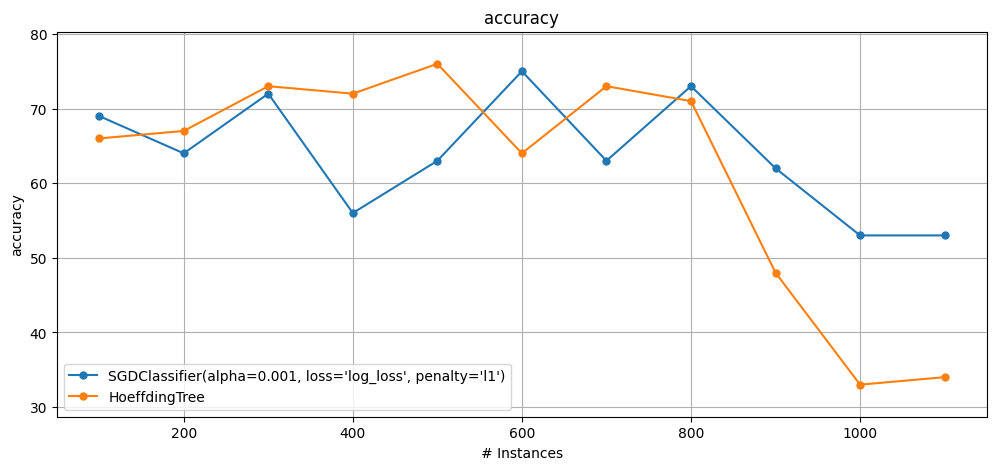

In [5]:
from capymoa.base import SKClassifier, MOAClassifier
from capymoa.datasets import CovtypeTiny
from capymoa.evaluation import prequential_evaluation_multiple_learners
from capymoa.evaluation.visualization import plot_windowed_results

from sklearn.linear_model import SGDClassifier
from moa.classifiers.trees import HoeffdingTree

covt_tiny = CovtypeTiny()

sk_sgd = SKClassifier(
    schema=covt_tiny.schema,
    sklearner=SGDClassifier(loss="log_loss", penalty="l1", alpha=0.001),
)
moa_ht = MOAClassifier(schema=covt_tiny.schema, moa_learner=HoeffdingTree, CLI="-g 50")

results = prequential_evaluation_multiple_learners(
    stream=covt_tiny, learners={"sk_sgd": sk_sgd, "moa_ht": moa_ht}, window_size=100
)
plot_windowed_results(results["sk_sgd"], results["moa_ht"], metric="accuracy")

## 4. Creating Python learners with MOA Objects

* This follows the example from `05_new_learner` which shows how to create a custom online bagging implementation.
* Here we also create an online bagging implementation, but the `base_learner` is a MOA class instead.

In [6]:
from capymoa.base import Classifier, MOAClassifier
from moa.classifiers.trees import HoeffdingTree
from collections import Counter
import numpy as np


class CustomOnlineBagging(Classifier):
    def __init__(
        self,
        schema=None,
        random_seed=1,
        ensemble_size=5,
        moa_base_learner_class=None,
        CLI_base_learner=None,
    ):
        super().__init__(schema=schema, random_seed=random_seed)

        self.CLI_base_learner = CLI_base_learner

        self.ensemble_size = ensemble_size
        self.moa_base_learner_class = moa_base_learner_class

        # Default base learner if None is specified
        if self.moa_base_learner_class is None:
            self.moa_base_learner_class = HoeffdingTree

        self.ensemble = []
        # Create several instances for the base_learners
        for _ in range(self.ensemble_size):
            self.ensemble.append(
                MOAClassifier(
                    schema=self.schema,
                    moa_learner=self.moa_base_learner_class(),
                    CLI=self.CLI_base_learner,
                )
            )

    def __str__(self):
        return "CustomOnlineBagging"

    def train(self, instance):
        for i in range(self.ensemble_size):
            for _ in range(np.random.poisson(1.0)):
                self.ensemble[i].train(instance)

    def predict(self, instance):
        predictions = []
        for i in range(self.ensemble_size):
            predictions.append(self.ensemble[i].predict(instance))
        majority_vote = Counter(predictions)
        prediction = majority_vote.most_common(1)[0][0]
        return prediction

    def predict_proba(self, instance):
        probabilities = []
        for i in range(self.ensemble_size):
            classifier_proba = self.ensemble[i].predict_proba(instance)
            classifier_proba = classifier_proba / np.sum(classifier_proba)
            probabilities.append(classifier_proba)
        avg_proba = np.mean(probabilities, axis=0)
        return avg_proba

### 4.1 Testing the custom online bagging

* We choose to use an HoeffdingAdaptiveTree from MOA as the base learner.
* We also specify the CLI commands to configure the base learner.

In [7]:
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import Electricity
from moa.classifiers.trees import HoeffdingAdaptiveTree

elec_stream = Electricity()

# Creating a learner: using a hoeffding adaptive tree as the base learner with grace period of 50 (-g 50)
NEW_OB = CustomOnlineBagging(
    schema=elec_stream.get_schema(),
    ensemble_size=5,
    moa_base_learner_class=HoeffdingAdaptiveTree,
    CLI_base_learner="-g 50",
)

results_NEW_OB = prequential_evaluation(
    stream=elec_stream, learner=NEW_OB, window_size=4500
)

print(f"Accuracy: {results_NEW_OB.cumulative.accuracy()}")

Accuracy: 86.54881709039547


## 5. Using TensorBoard with PyTorch in CapyMOA

* One can use TensorBoard to visualise logged data in an online fashion.
* We go through all the steps below, including installing TensorBoard.

### 5.1 Install TensorBoard

Clear any logs from previous runs.

```sh
rm ./notebooks/runs/*
```

In [8]:
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


### 5.2  PyTorchClassifier

* We define `PyTorchClassifier` and `NeuralNetwork` classes similarly to those from **Tutorial 3**: `Using Pytorch with CapyMOA`.

In [9]:
from capymoa.base import Classifier
import torch
from torch import nn

torch.manual_seed(1)
torch.use_deterministic_algorithms(True)

# Get cpu device for training.
device = "cpu"


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=0, number_of_classes=0):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, number_of_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class PyTorchClassifier(Classifier):
    def __init__(
        self,
        schema=None,
        random_seed=1,
        nn_model: nn.Module = None,
        optimiser=None,
        loss_fn=nn.CrossEntropyLoss(),
        device=("cpu"),
        lr=1e-3,
    ):
        super().__init__(schema, random_seed)
        self.model = None
        self.optimiser = None
        self.loss_fn = loss_fn
        self.lr = lr
        self.device = device

        torch.manual_seed(random_seed)

        if nn_model is None:
            self.set_model(None)
        else:
            self.model = nn_model.to(device)
        if optimiser is None:
            if self.model is not None:
                self.optimiser = torch.optim.SGD(self.model.parameters(), lr=lr)
        else:
            self.optimiser = optimiser

    def __str__(self):
        return str(self.model)

    def cli_help(self):
        return str(
            'schema=None, random_seed=1, nn_model: nn.Module = None, optimiser=None, loss_fn=nn.CrossEntropyLoss(), device=("cpu"), lr=1e-3'
        )

    def set_model(self, instance):
        if self.schema is None:
            moa_instance = instance.java_instance.getData()
            self.model = NeuralNetwork(
                input_size=moa_instance.get_num_attributes(),
                number_of_classes=moa_instance.get_num_classes(),
            ).to(self.device)
        elif instance is not None:
            self.model = NeuralNetwork(
                input_size=self.schema.get_num_attributes(),
                number_of_classes=self.schema.get_num_classes(),
            ).to(self.device)

    def train(self, instance):
        if self.model is None:
            self.set_model(instance)

        X = torch.tensor(instance.x, dtype=torch.float32)
        y = torch.tensor(instance.y_index, dtype=torch.long)
        # set the device and add a dimension to the tensor
        X, y = (
            torch.unsqueeze(X.to(self.device), 0),
            torch.unsqueeze(y.to(self.device), 0),
        )

        # Compute prediction error
        pred = self.model(X)
        loss = self.loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        self.optimiser.step()
        self.optimiser.zero_grad()

    def predict(self, instance):
        return np.argmax(self.predict_proba(instance))

    def predict_proba(self, instance):
        if self.model is None:
            self.set_model(instance)
        X = torch.unsqueeze(
            torch.tensor(instance.x, dtype=torch.float32).to(self.device), 0
        )
        # turn off gradient collection
        with torch.no_grad():
            pred = np.asarray(self.model(X).numpy(), dtype=np.double)
        return pred

### 5.3  PyTorchClassifier + the test-then-train loop + TensorBoard

* Here we use an instance loop to log relevant information to TensorBoard.
* This information can be viewed while the processing is happening using TensorBoard.

In [10]:
from capymoa.evaluation import ClassificationEvaluator
from capymoa.datasets import Electricity
from torch.utils.tensorboard import SummaryWriter

# Create a SummaryWriter instance.
writer = SummaryWriter()
# Opening a file again to start from the beginning
stream = Electricity()

# Creating the evaluator
evaluator = ClassificationEvaluator(schema=stream.get_schema())

# Creating a learner
simple_pyTorch_classifier = PyTorchClassifier(
    schema=stream.get_schema(),
    nn_model=NeuralNetwork(
        input_size=stream.get_schema().get_num_attributes(),
        number_of_classes=stream.get_schema().get_num_classes(),
    ).to(device),
)

i = 0
while stream.has_more_instances():
    i += 1
    instance = stream.next_instance()

    prediction = simple_pyTorch_classifier.predict(instance)
    evaluator.update(instance.y_index, prediction)
    simple_pyTorch_classifier.train(instance)

    if i % 1000 == 0:
        writer.add_scalar("accuracy", evaluator.accuracy(), i)

    if i % 10000 == 0:
        print(f"Processed {i} instances")

writer.add_scalar("accuracy", evaluator.accuracy(), i)
# Call flush() method to make sure that all pending events have been written to disk.
writer.flush()

# If you do not need the summary writer anymore, call close() method.
writer.close()

Processed 10000 instances
Processed 20000 instances
Processed 30000 instances
Processed 40000 instances


### 5.4 Run TensorBoard

Now, start TensorBoard, specifying the root log directory you used above. Argument `logdir` points to directory where TensorBoard will look to find event files that it can display. TensorBoard will recursively walk through the directory structure located at `logdir`, looking for `.*tfevents.*` files.

```sh
tensorboard --logdir=notebooks/runs
```
Go to the URL it provides.

This dashboard shows how the accuracy changes with time. You can use it to also track training speed, learning rate, and other scalar values.

## 6. Creating a synthetic stream with concept drifts from MOA

* Here we demonstrate the level of API flexibility that is expected from experienced MOA users.
* To use the API like this, the user must be familiar with how concept drifts are simulated in MOA.

For example:
* EvaluatePrequential 
    * -l trees.HoeffdingAdaptiveTree 
    * **-s (ConceptDriftStream -s generators.AgrawalGenerator -d (generators.AgrawalGenerator -f 2) -p 5000)**
    * -e (WindowClassificationPerformanceEvaluator **-w 100**)
    * **-i 10000**
    * **-f 100**

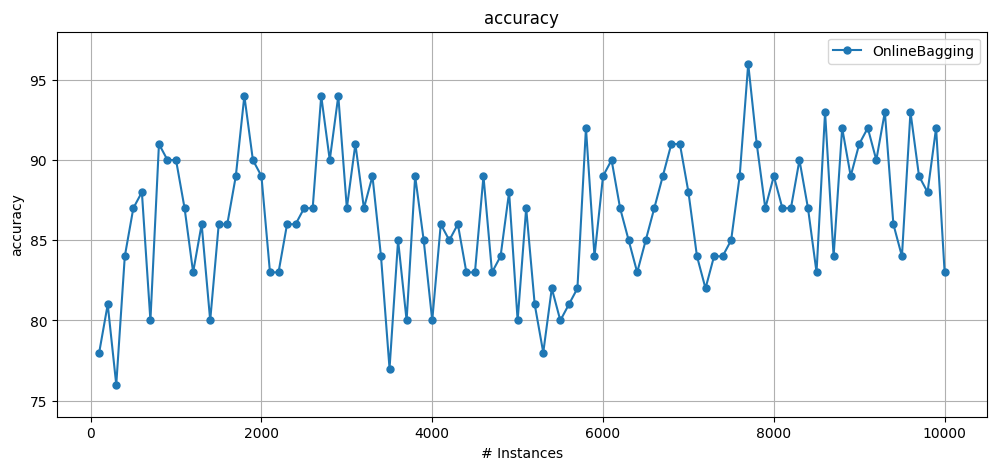

In [11]:
from capymoa.stream import MOAStream
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from moa.streams import ConceptDriftStream

# Using the API to generate the data using the ConceptDriftStream and SEAGenerator.
# The drift location is based on the number of instances (5000) as well as the drift width (1000, the default value).
stream_sea1drift = MOAStream(
    moa_stream=ConceptDriftStream(),
    CLI="-s generators.SEAGenerator -d (generators.SEAGenerator -f 2) -p 5000 -w 1000",
)

OB = OnlineBagging(schema=stream_sea1drift.get_schema(), ensemble_size=10)

results_sea1drift_OB = prequential_evaluation(
    stream=stream_sea1drift, learner=OB, window_size=100, max_instances=10000
)

plot_windowed_results(results_sea1drift_OB, metric="accuracy")

## 7. Drift, Multi-threaded Ensemble and Results

* Generate a stream with 3 drifts: 2 abrupt and one gradual.
* Evaluate utilising test-then-train (cumulative) and windowed evaluation.
* Execute a multi-threaded version of `AdaptiveRandomForest`.
* For more on multi-threaded ensembles, see the **parallel_ensembles.ipynb** notebook.

None
Cumulative accuracy = 89.316
Wallclock = 21.98450255393982 seconds


,instances,accuracy,kappa,kappa_t,kappa_m,f1_score,f1_score_0,f1_score_1,precision,precision_0,precision_1,recall,recall_0,recall_1
0,5000.0,88.24,73.655083,74.289462,67.040359,87.010721,82.437276,91.160553,88.238718,88.235294,88.242142,85.816434,77.354260,94.278607
1,10000.0,89.04,75.824986,76.867877,70.152505,88.084781,84.152689,91.623357,89.212603,89.704069,88.721137,86.985119,79.248366,94.721871
2,15000.0,89.20,76.244122,76.972281,70.684039,88.278420,84.482759,91.717791,89.339374,89.743590,88.935158,87.242369,79.804560,94.680177
3,20000.0,88.58,74.765545,75.712463,68.678003,87.530191,83.434871,91.286434,88.571385,88.546798,88.595972,86.513193,78.880965,94.145420
4,25000.0,89.88,77.409403,77.689594,71.492958,88.820849,85.020722,92.358804,89.801320,89.582034,90.020606,87.861557,80.901408,94.821705
5,30000.0,89.22,75.974731,76.595745,69.871437,88.127738,84.086212,91.849388,89.191203,89.111389,89.271017,87.089334,79.597541,94.581127
6,35000.0,89.36,75.905391,75.927602,68.870685,88.021791,83.810103,92.076259,88.809299,87.317692,90.300906,87.248127,80.573435,93.922820
7,40000.0,89.68,77.061068,77.486911,71.285476,88.667576,84.850264,92.174704,89.713457,89.807334,89.619581,87.645799,80.411797,94.879800
8,45000.0,90.12,78.163781,79.120879,72.961138,89.253353,85.656214,92.464918,90.406670,91.218306,89.595034,88.129091,80.733443,95.524740
9,50000.0,89.84,77.379454,77.787495,71.540616,88.807902,85.041225,92.307692,89.785901,89.633768,89.938035,87.850979,80.896359,94.805599


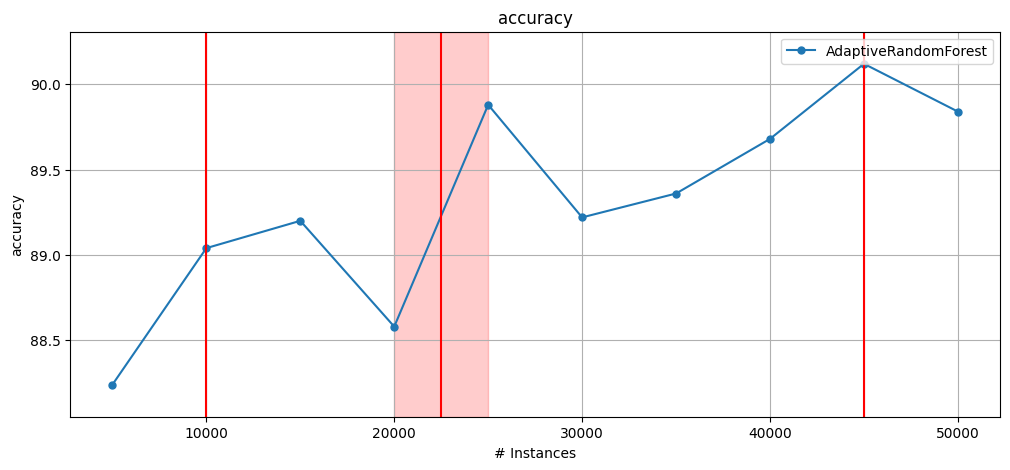

In [12]:
from capymoa.stream.generator import SEA
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.classifier import AdaptiveRandomForestClassifier
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

SEA3drifts = DriftStream(
    stream=[
        SEA(1),
        AbruptDrift(10000),
        SEA(2),
        GradualDrift(start=20000, end=25000),
        SEA(3),
        AbruptDrift(45000),
        SEA(1),
    ]
)

arf = AdaptiveRandomForestClassifier(
    schema=SEA3drifts.get_schema(), ensemble_size=100, number_of_jobs=4
)

results = prequential_evaluation(
    stream=SEA3drifts, learner=arf, window_size=5000, max_instances=50000
)

print(f"Cumulative accuracy = {results.cumulative.accuracy()}")
print(f"Wallclock = {results.wallclock()} seconds")
display(results.windowed.metrics_per_window())
plot_windowed_results(results, metric="accuracy")

## 8. AutoML with AutoClass

The following example shows how to use the `AutoClass` algorithm with CapyMOA. 
* AutoClass is configured using a json configuration file `settings_autoclass.json` and a list of classifiers `base_classifiers`.
* AutoClass can also be configured with a list of `base_classifier` strings representing the MOA classifiers. This approach is only enticing for people that are very familiar with MOA.
* In the example below, we also compare it against using the base classifiers individually.

[HT] Cumulative accuracy = 53.396, wall-clock time: 0.291323184967041
[HAT] Cumulative accuracy = 57.676, wall-clock time: 0.4058084487915039
[KNN] Cumulative accuracy = 86.956, wall-clock time: 2.6689324378967285
[AUTOCLASS] Cumulative accuracy = 86.336, wall-clock time: 80.88087701797485


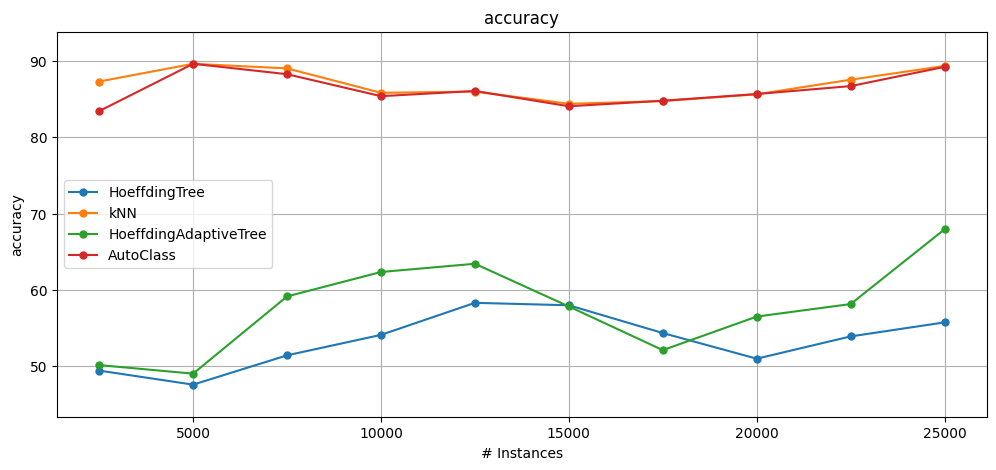

In [13]:
from capymoa.evaluation import prequential_evaluation
from capymoa.datasets import RBFm_100k
from capymoa.automl import AutoClass
from capymoa.classifier import HoeffdingTree, HoeffdingAdaptiveTree, KNN
from capymoa.evaluation.visualization import plot_windowed_results

rbf_100k = RBFm_100k()

max_instances = 25000
window_size = 2500

ht = HoeffdingTree(schema=rbf_100k.get_schema())
hat = HoeffdingAdaptiveTree(schema=rbf_100k.get_schema())
knn = KNN(schema=rbf_100k.get_schema())
autoclass = AutoClass(
    schema=rbf_100k.get_schema(),
    configuration_json="./settings_autoclass.json",
    base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree],
)

results_ht = prequential_evaluation(
    stream=rbf_100k, learner=ht, window_size=window_size, max_instances=max_instances
)
results_hat = prequential_evaluation(
    stream=rbf_100k, learner=hat, window_size=window_size, max_instances=max_instances
)
results_knn = prequential_evaluation(
    stream=rbf_100k, learner=knn, window_size=window_size, max_instances=max_instances
)
results_autoclass = prequential_evaluation(
    stream=rbf_100k,
    learner=autoclass,
    window_size=window_size,
    max_instances=max_instances,
)

print(
    f"[HT] Cumulative accuracy = {results_ht.accuracy()}, wall-clock time: {results_ht.wallclock()}"
)
print(
    f"[HAT] Cumulative accuracy = {results_hat.accuracy()}, wall-clock time: {results_hat.wallclock()}"
)
print(
    f"[KNN] Cumulative accuracy = {results_knn.accuracy()}, wall-clock time: {results_knn.wallclock()}"
)
print(
    f"[AUTOCLASS] Cumulative accuracy = {results_autoclass.accuracy()}, wall-clock time: {results_autoclass.wallclock()}"
)
plot_windowed_results(
    results_ht, results_knn, results_hat, results_autoclass, metric="accuracy"
)

### 8.1 AutoClass alternative syntax

Another way to configure the learners is by using a list of string `base_classifiers` representing the MOA classifiers.

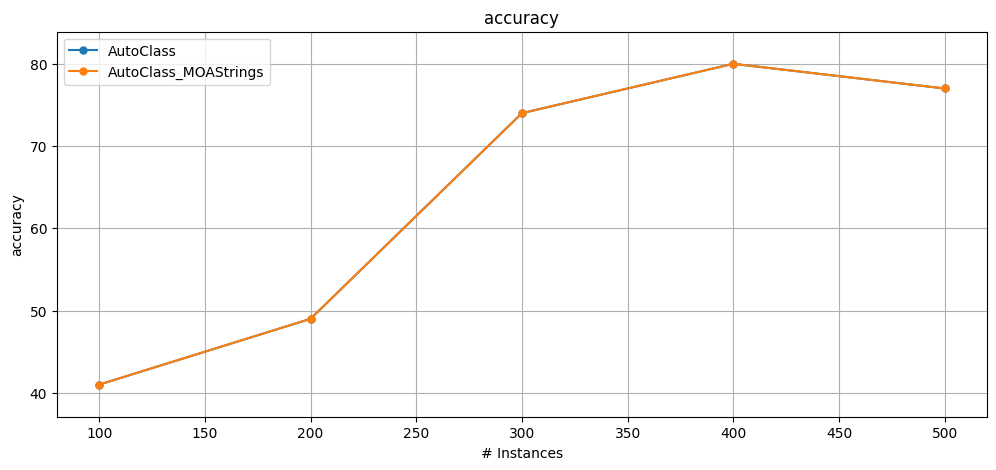

In [14]:
from capymoa.automl import AutoClass
from capymoa.datasets import RBFm_100k
from capymoa.classifier import KNN, HoeffdingTree, HoeffdingAdaptiveTree, OnlineBagging
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results

rbf_100k = RBFm_100k()

autoclass = AutoClass(
    schema=rbf_100k.get_schema(),
    configuration_json="./settings_autoclass.json",
    base_classifiers=[KNN, HoeffdingTree, HoeffdingAdaptiveTree],
)

autoclass_MOAStrings = AutoClass(
    schema=rbf_100k.get_schema(),
    configuration_json="./settings_autoclass.json",
    base_classifiers=["lazy.kNN", "trees.HoeffdingTree", "trees.HoeffdingAdaptiveTree"],
)

results_autoClass = prequential_evaluation(
    stream=rbf_100k, learner=autoclass, window_size=100, max_instances=500
)
results_autoclass_MOAStrings = prequential_evaluation(
    stream=rbf_100k, learner=autoclass_MOAStrings, window_size=100, max_instances=500
)

results_autoclass_MOAStrings.learner = "AutoClass_MOAStrings"

plot_windowed_results(
    results_autoClass, results_autoclass_MOAStrings, metric="accuracy"
)